# ¿Cómo realizar las asignaciones en Workforce mediante Python?

Este codigo fue realizado en base a la documentación oficial de ESRI, sin embargo, algunos parámetros fueron ajustados por el usuario José Córdova-Fredes, Geógrafo de la Pontificia Universidad Católica de Chile.
El código original esta en ingles, por lo que este insumo en español, espero sea de ayuda.

Nota

Es importante señalar que esta asignaciones seran realizadas de manera totalitaria, es decir, si yo tengo un csv con 10 tipos diferentes de asignaciones, al usuario X se le asignara esos 10 tipos.

Si tengo más de un usuario y se quiere realizar asignaciones especificadas, se e cargar un csv distinto para cada usuario, obviamente con asignaciones que no se crucen o que pueden duplicarse, este modo estará en otro Notebook llamadado "Asignaciones por zona".


Para cualquier duda con gusto ayudare, favor comunicarse a jcordovafredes@outlook.com


Este codigo esta en constante ajuste

# Importar librerias

Se importan las librerias que sean necesarias para correr el script,por una cosa de orden se sugiere que vaya todo al principio

In [1]:
import datetime
import json
import arcgis
from arcgis.gis import GIS
from arcgis.geometry import Geometry
from arcgis.apps import workforce

# Conectando organización

Es importante conectar el servidor (url) con el usuario respectivo del portal

In [2]:
gis = GIS("https://fau-uchile.maps.arcgis.com/", "jicoardova_fau")

Enter password: ········


# Workforce vacio

Es importante y relevante empezar con un proyecto vacio, esto es de suma importancia, puesto que es posible que no funcione y arroje errores.

In [16]:
item = gis.content.get("8d7d9354c68e44419b618bbc55899bdd")
project = workforce.Project(item)
project

<Project Proyectos de asignaciones de grifos con Python>

# Agregar tipo de asignaciones

Agregar asignaciones, no las borra, ni las reemplazas
Es importante indicar que si arroja error de asignacion, se debe crear un workforce vacio nuevamente

In [17]:
grifos = project.assignment_types.add(name="Inspección de grifos")
camaras = project.assignment_types.add(name="Inspección de camaras")
riles = project.assignment_types.add(name="Inspección de Riles")

# Se Agregan Trabajadores

En este apartado es relevante crear un grupo exclusivo para trabajadores e incorporar a los usuarios "trabajadores"

In [18]:
trabajadores = gis.groups.get("5573ec020617466288bd149990d1ace0")
trabajadores

<Group title:"Trabajadores" owner:jicoardova_fau>

In [19]:
for username in trabajadores.get_members()["users"]:
    user = gis.users.get(username)
    project.workers.add(
        user_id=username,
        name=user.fullName,
        status="not_working",
        title="Trabajador de campo"
    )

# Se agregan los supervisores

En este apartado es relevante crear un grupo exclusivo para Supervisores y asi incorporarlos

<Group title:"Supervisores" owner:jicoardova_fau>
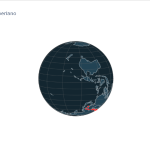

In [20]:
supervisores_grifos = gis.groups.get("be5f84c01c2d404ca78ec97ad5c17ee0")
supervisores_grifos

In [21]:
for username in supervisores_grifos.get_members()["users"]:
    if username != "jicoardova_fau":
        user = gis.users.get(username)
        project.dispatchers.add(
            user_id=username,
            name=user.fullName
        )

# Agregar integracion de explorer

Básicamente se agrega un mapa con toda la información de capas llamese puntos, lineas y poligonos, esto es relevante para darle contexto a la futura asignación

In [22]:
from arcgis.apps import build_explorer_url
from arcgis.mapping import WebMap

webmap = WebMap(gis.content.get("cbcbc17fdbff4e3697300d585366b817"))
webmap.item.share(groups=[project.group])
webmap

MapView(hide_mode_switch=True, layout=Layout(height='400px', width='100%'))

In [23]:
url = build_explorer_url(
    webmap=webmap,
    center="${assignment.latitude},${assignment.longitude}",
    url_type="App",
    scale=9000
)

In [24]:
project.integrations.add("default-explorer", "Explorer At Assignment", url)

<Integration default-explorer>

# Conectar y leer csv

Es importante que antes de cargar un csv, se instala e importe la libreria Pandas

In [25]:
import pandas as pd

En cuanto al como cargar un archivos csv, depende de cada configuración; en mi caso es relevante colocar la f antes de la dirección de la carpeta donde contiene el archivo csv y uso /.

In [26]:
assignments = f'C:/Users/jcord/OneDrive/Escritorio/XYGO/Scripts/asignaciones.csv'
df = pd.read_csv(assignments, sep=";")
df

,1,Location,Description,Assigned,Priority,Work Order Id,Due Date
0,2,"Papudo 815, La Ligua",Zona 1: Colo Colo,andraes.smgo_fau,high,1,30/8/2021 22:43
1,3,"Avenida Holanda 34, La Ligua",Zona 2: San Luis,INTERGEO_04,medium,2,31/8/2021 21:43
2,4,"Laulie 098, La Ligua",Zona 3: Deportes PM,INTERGEO_04,low,3,1/9/2021 19:43
3,5,"Diego Portales 699, La Ligua",Zona 4: Naval,INTERGEO_06,critical,4,2/9/2021 10:43
4,6,"Luis Cruz Martinez 690, La Ligua",Zona 5: Tricolor,INTERGEO_06,high,5,3/9/2021 18:43
5,7,"Ignacio Carrera Pinto 830, La Ligua",Zona 6: Lozapenco FC,andraes.smgo_fau,low,6,4/9/2021 14:00


# Buscar y asignar a los usuarios

Aca se busca crear una variable con los nombres, que ya ingresemos anteriormente en el "Grupo de Trabajadores"

In [46]:
Daniela = project.workers.get(user_id="INTERGEO_04")
Felipe = project.workers.get(user_id="INTERGEO_06")
Andres = project.workers.get(user_id="andraes.smgo_fau")

# Crear una asignación para cada fila

1. Para cada asignación, primero codifique geográficamente la dirección para obtener la ubicación x, y en (WGS84 Web Mercator) de la asignación. Luego proporcione atributos adicionales

2. Finalmente, use el método batch_add para agregar múltiples asignaciones a la vez (esto es más rápido que usar el método add ya que la validación se realiza una vez para todas las asignaciones)

Quizasla siguiente linea de codigo no es necesario que vaya, puesto que las asignaciones ya se realizaron con anterioridad; igualmente se sugiere que las asignaciones vayan a partir de este punto


In [29]:
assignment_types = project.assignment_types.add(name="Inspección de Grifo")

In [30]:
from arcgis.geocoding import geocode
from datetime import datetime

### 1. Asignación para el Trabajador "Daniela"

In [58]:
assignments = []
for index, row in df.iterrows():
    geometry = geocode(f"{row['Location']}", out_sr=3857)[0]["location"]
    assignments.append(
        workforce.Assignment(
            project,
            geometry=geometry,
            location=row["Location"],
            description=row["Description"],
            priority=row["Priority"],
            work_order_id=row["Work Order Id"],
            assignment_type="Inspección de Grifo",
            status="assigned",
            worker= Daniela,
            due_date=pd.to_datetime(row["Due Date"])
        )
    )

In [59]:
#Agregar asignaciones con el metodo batch_add
project.assignments.batch_add(assignments)

[<Assignment 31>,
 <Assignment 32>,
 <Assignment 33>,
 <Assignment 34>,
 <Assignment 35>,
 <Assignment 36>]

### 2. Asignación para el Trabajador "Felipe"

In [52]:
assignments = []
for index, row in df.iterrows():
    geometry = geocode(f"{row['Location']}", out_sr=3857)[0]["location"]
    assignments.append(
        workforce.Assignment(
            project,
            geometry=geometry,
            location=row["Location"],
            description=row["Description"],
            priority=row["Priority"],
            work_order_id=row["Work Order Id"],
            assignment_type="Inspección de Grifo",
            status="assigned",
            worker= Felipe,
            due_date=pd.to_datetime(row["Due Date"])
        )
    )

In [53]:
#Agregar asignaciones con el metodo batch_add
project.assignments.batch_add(assignments)

[<Assignment 19>,
 <Assignment 20>,
 <Assignment 21>,
 <Assignment 22>,
 <Assignment 23>,
 <Assignment 24>]

### 3.Asignación para el Trabajador "Andres"

In [54]:
assignments = []
for index, row in df.iterrows():
    geometry = geocode(f"{row['Location']}", out_sr=3857)[0]["location"]
    assignments.append(
        workforce.Assignment(
            project,
            geometry=geometry,
            location=row["Location"],
            description=row["Description"],
            priority=row["Priority"],
            work_order_id=row["Work Order Id"],
            assignment_type="Inspección de Grifo",
            status="assigned",
            worker= Andres,
            due_date=pd.to_datetime(row["Due Date"])
        )
    )

In [55]:
#Agregar asignaciones con el metodo batch_add
project.assignments.batch_add(assignments)

[<Assignment 25>,
 <Assignment 26>,
 <Assignment 27>,
 <Assignment 28>,
 <Assignment 29>,
 <Assignment 30>]

In [150]:
#Linea en desarrollo
#Borrar asignaciones con el metodo batch_delete (en desarrollo)
#project.assignments.batch_delete(assignments)

# Se visualizan la cantidad de asignaciones realizadas

In [56]:
#Buscar todas las asignaciones
assignments = project.assignments.search()
assignments

[<Assignment 1>,
 <Assignment 2>,
 <Assignment 3>,
 <Assignment 4>,
 <Assignment 5>,
 <Assignment 6>,
 <Assignment 7>,
 <Assignment 8>,
 <Assignment 9>,
 <Assignment 10>,
 <Assignment 11>,
 <Assignment 12>,
 <Assignment 13>,
 <Assignment 14>,
 <Assignment 15>,
 <Assignment 16>,
 <Assignment 17>,
 <Assignment 18>,
 <Assignment 19>,
 <Assignment 20>,
 <Assignment 21>,
 <Assignment 22>,
 <Assignment 23>,
 <Assignment 24>,
 <Assignment 25>,
 <Assignment 26>,
 <Assignment 27>,
 <Assignment 28>,
 <Assignment 29>,
 <Assignment 30>]

# Descripción de las asignaciones

In [51]:
assignment = assignments[0]
print(f"Status: {assignment.status}")
print(f"Description: {assignment.description}")
print(f"Priority: {assignment.priority}")
print(f"Assigned To: {assignment.worker}")
print(f"Type: {assignment.assignment_type}")
print(f"Due Date: {assignment.due_date}")

Status: assigned
Description: Zona 1: Colo Colo
Priority: high
Assigned To: Daniela Duque Ramos (INTERGEO_04)
Type: Inspección de Grifo
Due Date: 2021-08-30 22:43:00+00:00


# Verificar asignaciones en el mapa

In [57]:
webmap = gis.map("La Ligua", zoomlevel=12)
webmap.add_layer(project.assignments_layer)
webmap

MapView(layout=Layout(height='400px', width='100%'))